# 实验报告：基于 DQN 的无人机通信决策

## 1. 实验背景

本实验旨在利用深度 Q 网络（DQN）对无人机（UAV）的通信调度决策进行优化。实验环境设定中包含三个地点：  
- **L0（Home）**  
- **L1**  
- **L2**

在 L1 和 L2 地点，以各自独立的概率随机产生警报。无人机需要及时飞往警报发生地点，执行消除警报的动作，从而降低警报"延迟累积代价"（Age of Missed Alarm，AoMA），同时确保自身不会因为电量耗尽而坠机。

## 2. 系统设定与细节

### 2.1 物理参数变量化

实验中所有物理参数均用单独的变量表示，便于实验时进行参数调整和调试，主要包括以下变量：

- **地点之间的距离**：  
  示例：`d_L0_L1`、`d_L0_L2`、`d_L1_L2`  
  （距离与飞行所需时间/能量消耗成1:1关系，例如 L0 到 L1 的距离 20 意味着 UAV 需要花费 20 个时间步和 20 单位能量）

- **充电速率**：  
  示例：`charging_rate`  
  （charging_rate = 10 代表在 Home（L0）停留每个时间单位获得 10 单位能量）

- **警报消除动作消耗的能量**：  
  示例：`remove_cost`  
  （当 UAV 在警报地点执行消除警报动作需要消耗的能量，具体值可在实验中调试）

- **无人机电池最大容量**：  
  示例：`battery_capacity`  
  （电池能量永远不会超过此上限）

- **警报生成概率**：  
  示例：`p_L1` 和 `p_L2` 分别对应 L1 和 L2 生成警报的概率  
  （注意：在一个地点已有未解决的警报时，该地点不会再次生成新的警报，直到当前警报被处置）

### 2.2 警报和 AoMA 计算

#### 警报生成
- **生成规则**：  
  L1 和 L2 的警报生成是相互独立的。  
  当某个地点产生警报后，在此警报被消除之前，不会再次生成新的警报。

#### AoMA 定义
- **AoMA 计算方式**：  
  对于某个警报，从其产生开始到 UAV 执行消除动作结束，中间经历的每一步都会累加代价。  
  如果警报在第 n 个时间步被解决，则该警报的最终 AoMA 为等差求和：1+2+3+...+n。

### 2.3 UAV Agent 的学习目标

无人机 Agent 通过 DQN 学习，在一定的仿真时间内需要同时满足两个目标：
1. **降低累计 AoMA**：  
   尽量减少所有警报从出现到消除期间积累的代价。
2. **确保飞行安全**：  
   UAV 必须保持足够的电量，避免因为电能不足而无法执行任务或返回 Home，进而坠机。

## 3. 状态、动作与奖励设计构想

### 3.1 状态空间

状态可能包含但不限于以下信息：
- 当前时间步
- UAV 的当前位置（例如可以是 0 表示在 L0，1 表示在 L1，2 表示在 L2）
- 当前电池剩余能量
- L1、L2 是否存在未解决的警报（布尔变量）
- 对于存在警报的地点，记录警报已等待的时间（用于计算 AoMA）

### 3.2 动作空间

动作可以设计为以下几种基本操作：
- 飞往 L1  
- 飞往 L2  
- 飞往 L0（Home）进行充电  
- 在警报地点执行消除警报动作（执行该动作时，需保证 UAV 已到达警报地点并消耗相应能量）

> 注意：飞行和消除警报可能拆分成独立动作，也可以考虑将到达并消除动作合并，具体设计可以根据实际实验需求调整。

### 3.3 奖励函数

奖励函数的设计需要兼顾两个目标：
1. **AoMA 惩罚**：  
   对每个时间步，根据当前所有未消除警报的累积 AoMA 进行惩罚（例如，警报越长时间未解决，累计惩罚越高）。
2. **能量安全奖励/惩罚**：
   - 如果 UAV 因电量耗尽而无法执行任务（例如进入一个可能坠机状态），则需要给予较大的负面奖励；
   - 在 Home（L0）充电过程中可以给予正面激励，但同时也要考虑充电与任务延误之间的平衡。

## 4. 实验流程概述

1. **初始化**：  
   设置各个变量（距离、充电速率、消除警报消耗能量、电池最大容量、L1 和 L2的警报生成概率），无人机初始位置设为 L0（Home），电池满格。

2. **环境仿真**：  
   模拟每个时间步：
   - 根据预设概率判断 L1 和 L2 是否生成警报（若当前不存在未解决警报时才生成）。
   - 更新警报等待时间（用于计算 AoMA）。
   - UAV 根据 DQN 输出动作，执行飞行、充电或消除警报动作，并消耗/补充能量。
   - 计算当步奖励并更新累计 AoMA。
   - 检查 UAV 是否因能量不足而坠机（即当前电量不足以支撑必要飞行）。

3. **DQN 训练**：  
   - 采用设计好的状态和动作空间，以及奖励函数进行 DQN 学习；
   - 在训练过程中不断调整变量（如消除警报消耗能量）和网络参数，以优化降低累计 AoMA 和确保能量安全的策略。

4. **实验评估**：  
   - 记录每次仿真中的累计 AoMA；
   - 分析 UAV 在不同参数设置下的决策表现；
   - 实验中需要不断试验不同参数以寻找最佳学习策略。


# 奖励函数
设在时间步 $t$，UAV的奖励函数为：

$$R_t = R_{action} + R_{alarm} + R_{battery} + R_{penalty}$$

1. 动作相关奖励 ($R_{action}$)
成功消除警报奖励： $$R_{clear} = \max(5, 60 - \frac{(w_i + 1)(w_i + 2)}{40})$$

其中 $w_i$ 是警报在地点 $i$ 的等待时间。

无效动作惩罚： $$R_{invalid} = -20$$

2. 警报持续惩罚 ($R_{alarm}$)
对于每个时间单位 $\Delta t$： $$R_{alarm} = -\sum_{i \in {L1, L2}} \alpha \cdot (0.8 + 1.5 \cdot \frac{w_i}{w_{max}}) \cdot \mathbf{1}(w_i > 0)$$

其中：

$\alpha = 2$（警报惩罚率）
$w_{max} = 100$（最大警报等待时间）
$\mathbf{1}(\cdot)$ 是指示函数

3. 电池安全奖励 ($R_{battery}$)
$$R_{battery} = \begin{cases} 0.1 & \text{if } B_t > 20 \ -(B_{max} - B_t) + 60 & \text{if } B_t \leq 20 \end{cases}$$

其中 $B_t$ 是当前电量，$B_{max} = 80$ 是最大电池容量。

4. 严重违规惩罚 ($R_{penalty}$)
电量耗尽/抛锚惩罚： $$R_{anchor} = -1000$$

警报超时惩罚： $$R_{timeout} = -800 \quad \text{当 } w_i > w_{max}$$

完整奖励函数
因此，完整的奖励函数为：

$$R_t = \begin{cases} R_{clear} + R_{alarm} + R_{battery} & \text{正常执行动作} \ R_{invalid} + R_{alarm} + R_{battery} & \text{无效动作} \ R_{anchor} & \text{电量不足抛锚} \ R_{timeout} & \text{警报等待超时} \end{cases}$$

其中每个时间步都会累加警报持续惩罚和电池安全奖励，而动作相关的奖励则根据具体执行的动作类型确定。

In [1]:
import random
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
# ---------------------------
# 环境定义
# ---------------------------
class UAVEnv:
    def __init__(self):
        # 地点表示: 0: L0 (Home), 1: L1, 2: L2
        # 物理参数
        self.d_L0_L1 = 10
        self.d_L0_L2 = 20
        self.d_L1_L2 = 15  # 假设 L1 到 L2距离（对称）
        self.charging_rate = 20  # 充电速率
        self.remove_cost = 5     # 消除警报消耗能量（可调）
        self.battery_capacity = 80
        
        # 警报生成概率（独立变量）
        self.p_L1 = 0.017
        self.p_L2 = 0.012


        # 调整惩罚和奖励参数
        self.max_alarm_age = 100  # 降低最大等待时间
        self.anchor_penalty = 1000  # 降低抛锚惩罚
        self.max_age_penalty = 800
        self.clear_reward_base = 10  # 降低基础奖励

        # 定义最大步数
        self.max_steps = 10000      
        self.alarm_penalty_rate = 2  # 降低持续惩罚
        
        self.reset()

    def reset(self):
        # 当前时间步
        self.t = 0
        # UAV位置，初始在L0(Home)
        self.pos = 0
        # 充满电
        self.battery = self.battery_capacity
        
        # 对每个地点的警报状态：如果有警报，记录等待时间（初始值为1）
        # 如果没有警报，记为0
        self.alarm_L1 = 0  
        self.alarm_L2 = 0  
        
        # 累计 AoMA
        self.aoa_total = 0
        # 为统计每个警报的 AoMA，存储 (地点, waiting_time)，
        # 当报警被清除时，计算代价: waiting_time*(waiting_time+1)/2
        # 但这里我们只累加至 self.aoa_total
        # episode 中是否因能量不足抛锚
        self.anchored = False
        # 本 episode 警报总次数
        self.alarm_count = 0
        self.stop_reason = "NO"
        return self._get_state()

    def _get_state(self):
        # 状态: [当前所在位置(one-hot 3维), 剩余电量归一化, alarm_L1等待时间归一化, alarm_L2等待时间归一化]
        pos_onehot = [1 if self.pos == i else 0 for i in range(3)]
        norm_battery = self.battery / self.battery_capacity
        # 用最大允许等待时长做归一化并截断到 [0,1]
        norm_alarm1 = min(self.alarm_L1, self.max_alarm_age) / self.max_alarm_age
        norm_alarm2 = min(self.alarm_L2, self.max_alarm_age) / self.max_alarm_age
        state = np.array(pos_onehot + [norm_battery, norm_alarm1, norm_alarm2], dtype=np.float32)
        return state

    def _get_distance(self, from_pos, to_pos):
        if from_pos == to_pos:
            return 0
        if {from_pos, to_pos} == {0, 1}:
            return self.d_L0_L1
        if {from_pos, to_pos} == {0, 2}:
            return self.d_L0_L2
        if {from_pos, to_pos} == {1, 2}:
            return self.d_L1_L2
        return 0

    def step(self, action):
        """
        动作定义:
         0: 移动到 L0 (如果已在L0，则代表在Home充电)
         1: 移动到 L1
         2: 移动到 L2
         3: 执行消除警报动作（前提是在对应地点且有警报）
        """
        reward = 0.0

        # 默认时间步增量为1
        delta_time = 1

        # 处理动作
        if action in [0, 1, 2]:
            target = action  # 目标地点
            if self.pos != target:
                # 计算移动需要的耗时和能量
                dist = self._get_distance(self.pos, target)
                # 如果电量不足以完成移动，则 UAV 抛锚，episode结束
                if self.battery < dist:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                # 飞行过程消耗能量
                self.battery -= dist
                delta_time = dist
                self.pos = target
            # 如果移动到 L0，则代表可以充电
            if self.pos == 0:
                charge = self.charging_rate * delta_time
                self.battery = min(self.battery + charge, self.battery_capacity)
        elif action == 3:
            # 执行消除警报动作
            if self.pos == 1 and self.alarm_L1 > 0:
                # 检查电量是否充足进行消除
                if self.battery < self.remove_cost:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                self.battery -= self.remove_cost
                t = self.alarm_L1
                # 累积 AoMA 统计
                self.aoa_total += t * (t + 1) / 2
                # 改进奖励：基于时间给予更合理的奖励
                time_bonus = max(5, 60 - (self.alarm_L1+1)*(self.alarm_L1+2)/40)   # 时间越短奖励越高
                reward += time_bonus
                self.alarm_L1 = 0
            elif self.pos == 2 and self.alarm_L2 > 0:
                if self.battery < self.remove_cost:
                    self.anchored = True
                    self.stop_reason = "Anchored"
                    reward -= self.anchor_penalty
                    return self._get_state(), reward, True, {"info": "anchored"}
                self.battery -= self.remove_cost
                t = self.alarm_L2
                self.aoa_total += t * (t + 1) / 2
                time_bonus = max(5, 60 - (self.alarm_L2+1)*(self.alarm_L2+2)/40)  # 时间越短奖励越高
                reward += time_bonus
                self.alarm_L2 = 0
            else:
                # 无效的消除动作
                reward -= 20
        else:
            # 非法动作
            reward -= 20

        # 新：对每个时间步进行逐步模拟，确保每一步都尝试生成警报
        for _ in range(delta_time):
            # 更新全局时间
            self.t += 1
            
            # 更新现有警报的等待时间
            if self.alarm_L1 > 0:
                self.alarm_L1 += 1
            if self.alarm_L2 > 0:
                self.alarm_L2 += 1

            # 计算惩罚
            alarm_penalty = 0
            if self.alarm_L1 > 0:
                alarm_penalty +=  self.alarm_penalty_rate*(0.8+ 1.5*self.alarm_L1/self.max_alarm_age)  # 增加惩罚随着等待时间增加
            if self.alarm_L2 > 0:
                alarm_penalty +=  self.alarm_penalty_rate*(0.8+ 1.5*self.alarm_L2/self.max_alarm_age)  # 增加惩罚随着等待时间增加
            reward -= alarm_penalty
            
            # 检查警报是否超过最大等待时间
            if self.alarm_L1 > self.max_alarm_age or self.alarm_L2 > self.max_alarm_age:
                self.maxed = True
                self.stop_reason = "AoMA_MAX"
                reward -= self.max_age_penalty
                return self._get_state(), reward, True, {"info": "max_age_exceeded"}
            
            # 尝试生成新的警报（每个时间步都检查）
            if self.alarm_L1 == 0 and random.random() < self.p_L1:
                self.alarm_L1 = 1
                self.alarm_count += 1
            if self.alarm_L2 == 0 and random.random() < self.p_L2:
                self.alarm_L2 = 1
                self.alarm_count += 1

        # 添加电量安全奖励
        if self.battery > 20:
            reward += 0.1  # 保持充足电量的奖励
        elif self.battery <= 20:
            reward -= (self.battery_capacity - self.battery) - 60  # 电量过低的惩罚

        # 如果超出最大步数或电量耗尽，则结束episode
        done = False
        if self.t >= self.max_steps or self.battery <= 0:
            done = True
            self.stop_reason = "✅"  # 添加这行
            # 如果因电量耗尽而结束，则给予惩罚
            if self.battery <= 0:
                self.anchored = True
                self.stop_reason = "Anchored"
                reward -= self.anchor_penalty

        return self._get_state(), reward, done, {}

# ---------------------------
# DQN Agent 定义
# ---------------------------
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # 增加网络深度和宽度
        self.net = nn.Sequential(
                    nn.Linear(input_dim, 128),   # 增加到128
                    nn.ReLU(),
                    nn.Linear(128, 64),          # 新增一层64
                    nn.ReLU(),
                    nn.Linear(64, 32),           # 保持32
                    nn.ReLU(),
                    nn.Linear(32, output_dim)    # 输出层
                )
        
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=2e-4, gamma=0.96, epsilon_start=0.95,
                 epsilon_end=0.01, epsilon_decay=0.997, memory_size=50000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma  # 降低gamma，让agent更关注短期奖励
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay  # 更慢的epsilon衰减
        self.batch_size = batch_size
        
        self.memory = deque(maxlen=memory_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.update_target_steps = 200  # 更频繁的目标网络更新

        self.step_count = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            qvals = self.policy_net(state)
        return int(torch.argmax(qvals, dim=1).item())

    def store_transition(self, transition):
        self.memory.append(transition)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states     = torch.FloatTensor(states).to(self.device)
        actions    = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards    = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states= torch.FloatTensor(next_states).to(self.device)
        dones      = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # 当前 Q
        qvals = self.policy_net(states).gather(1, actions)

        # Double DQN: 在线网路选动作，目标网路估值
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            next_qvals   = self.target_net(next_states).gather(1, next_actions)
            expected = rewards + self.gamma * next_qvals * (1 - dones)

        loss = self.loss_fn(qvals, expected)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step_count += 1
        if self.step_count % self.update_target_steps == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        # ε 衰减
        # self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_end)

# ---------------------------
# 训练过程与可视化
# ---------------------------
def train(num_episodes=5000):  # 减少episode数量先观察效果
    env = UAVEnv()
    state_dim = 3 + 3  # 3位置(one-hot) + (battery, alarm1, alarm2)
    action_dim = 4   # 动作：移动到L0, L1, L2, 执行消除警报动作
    agent = DQNAgent(state_dim, action_dim)
    
    episode_rewards = []
    episode_aoa = []
    anchored_count = []     # 改为列表
    aoma_max_count = []     # 改为列表
    success_count = []  

    # 添加滑动窗口平均以观察趋势
    window_size = 100
    window_size = 100
    
    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        # 记录本episode累计 AoMA（环境内部已统计在 env.aoa_total 中）
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            # 终止判断：如果由于抛锚，则将 done 置 True并设置特殊标记
            done_flag = 1.0 if done else 0.0
            agent.store_transition((state, action, reward, next_state, done_flag))
            agent.update()
            state = next_state
            total_reward += reward
            steps += 1
            # 如果因电量不足抛锚，则提前退出
            if info.get("info", "") == "anchored":
                break

        episode_rewards.append(total_reward)
        # 平均 AoMA = 累积 AoMA / 本 episode 警报总次数
        avg_aoa = env.aoa_total / env.alarm_count if env.alarm_count > 0 else 0
        # 修改统计方式 - 每个episode记录0或1
        if env.stop_reason == "✅":
            episode_aoa.append((avg_aoa, ep))
            anchored_count.append(0)
            aoma_max_count.append(0)
            success_count.append(1)
        elif env.stop_reason == "AoMA_MAX":
            anchored_count.append(0)
            aoma_max_count.append(1)
            success_count.append(0)
        elif env.stop_reason == "Anchored":
            anchored_count.append(1)
            aoma_max_count.append(0)
            success_count.append(0)
        else:
            anchored_count.append(0)
            aoma_max_count.append(0)
            success_count.append(0)
    

        # 每50集打印一次详细信息
        #if (ep + 1) % 50 == 0:
        print(
            f"Episode {ep+1:4d} | Reward: {total_reward:10.2f}"
            f" | Avg AoMA: {avg_aoa:8.2f} ({env.aoa_total:8} / {env.alarm_count:2d})"
            f" | Early Stop: {env.stop_reason}"
            f" | Stopped at: {env.t}"
            f" | epsilon: {agent.epsilon:.4f}"
        )
# 每个 episode 结束后再进行一次 epsilon 衰减
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_end)

    return agent, episode_rewards, episode_aoa, anchored_count, aoma_max_count, success_count

agent, rewards, aoa, anchors, aoma_max, success = train()

Episode    1 | Reward:   -1123.62 | Avg AoMA:   105.00 (   210.0 /  2) | Early Stop: Anchored | Stopped at: 101 | epsilon: 0.9500
Episode    2 | Reward:   -1318.89 | Avg AoMA:   778.33 (  2335.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 192 | epsilon: 0.9471
Episode    3 | Reward:   -1149.44 | Avg AoMA:     3.33 (    10.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 152 | epsilon: 0.9443
Episode    4 | Reward:   -1373.16 | Avg AoMA:    30.33 (    91.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 162 | epsilon: 0.9415
Episode    5 | Reward:   -1096.47 | Avg AoMA:   120.00 (   120.0 /  1) | Early Stop: Anchored | Stopped at: 100 | epsilon: 0.9387
Episode    6 | Reward:   -1313.46 | Avg AoMA:    92.00 (   276.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 173 | epsilon: 0.9358
Episode    7 | Reward:   -1173.30 | Avg AoMA:     0.00 (       0 /  1) | Early Stop: AoMA_MAX | Stopped at: 114 | epsilon: 0.9330
Episode    8 | Reward:   -1463.52 | Avg AoMA:   477.00 (  1431.0 /  3) | Early Stop: AoMA_

/var/folders/y8/6wsnwdks5qjbpgkbrp2ysk3r0000gp/T/ipykernel_45214/3328757367.py:258: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states     = torch.FloatTensor(states).to(self.device)


Episode   15 | Reward:   -1848.56 | Avg AoMA:  1430.50 (  8583.0 /  6) | Early Stop: Anchored | Stopped at: 317 | epsilon: 0.9109
Episode   16 | Reward:   -1233.00 | Avg AoMA:     0.00 (       0 /  1) | Early Stop: AoMA_MAX | Stopped at: 115 | epsilon: 0.9081
Episode   17 | Reward:   -1062.48 | Avg AoMA:    60.00 (   120.0 /  2) | Early Stop: Anchored | Stopped at: 70 | epsilon: 0.9054
Episode   18 | Reward:   -1355.86 | Avg AoMA:   690.00 (  2070.0 /  3) | Early Stop: Anchored | Stopped at: 178 | epsilon: 0.9027
Episode   19 | Reward:   -1330.62 | Avg AoMA:   360.33 (  1081.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 125 | epsilon: 0.9000
Episode   20 | Reward:   -1398.76 | Avg AoMA:  1701.50 (  3403.0 /  2) | Early Stop: AoMA_MAX | Stopped at: 175 | epsilon: 0.8973
Episode   21 | Reward:   -1357.37 | Avg AoMA:   247.00 (   741.0 /  3) | Early Stop: AoMA_MAX | Stopped at: 115 | epsilon: 0.8946
Episode   22 | Reward:   -1394.76 | Avg AoMA:     0.00 (       0 /  2) | Early Stop: AoMA_M

In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# ---------------------------
# Plotly 可视化（改进版）
# ---------------------------
def plot_training_results_plotly(rewards, aoa, anchors, aoma_max, success, window_size=100):
    episodes = np.arange(1, len(rewards)+1)
    
    def moving_average(data, window):
        return pd.Series(data).rolling(window=window, min_periods=1).mean().values
    
    rewards_ma = moving_average(rewards, window_size)
    anchors_ma = moving_average(anchors, window_size)
    aoma_max_ma = moving_average(aoma_max, window_size)
    success_ma = moving_average(success, window_size)  # 新增成功率滑动平均
    
    # 创建子图布局 (1行3列)
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=("Reward Curve", "AoMA Curve (Successful Episodes Only)", "Early Stop Types"),
        specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 第1个子图：Reward Curve
    # 原始数据作为背景（淡蓝色）
    fig.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards,
            mode='lines',
            name='Raw Reward',
            line=dict(color='lightblue', width=1, dash='solid'),
            opacity=0.6,
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 滑动平均（醒目颜色）
    fig.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards_ma,
            mode='lines',
            name=f'Reward MA({window_size})',
            line=dict(color='darkblue', width=3),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 第2个子图：AoMA Curve
    if aoa:  # 确保有成功完成的episode数据
        # 提取episode索引和对应的AoMA值
        aoa_episodes = [item[1] + 1 for item in aoa]  # episode索引 (从1开始显示)
        aoa_values = [item[0] for item in aoa]        # AoMA值
        
        # 计算AoMA的滑动平均
        aoa_ma = moving_average(aoa_values, min(window_size, len(aoa_values)))
        
        # 原始AoMA数据（淡红色背景）
        fig.add_trace(
            go.Scatter(
                x=aoa_episodes,
                y=aoa_values,
                mode='lines+markers',
                name='Raw AoMA',
                line=dict(color='lightcoral', width=1),
                marker=dict(size=2, color='lightcoral'),
                opacity=0.6,
                showlegend=False
            ),
            row=1, col=2
        )
        
        # AoMA滑动平均（醒目红色）
        fig.add_trace(
            go.Scatter(
                x=aoa_episodes,
                y=aoa_ma,
                mode='lines',
                name=f'AoMA MA({window_size})',
                line=dict(color='crimson', width=3),
                showlegend=False
            ),
            row=1, col=2
        )
    else:
        # 添加文本提示
        fig.add_annotation(
            text="No successful episodes",
            x=0.5, y=0.5,
            xref="x2", yref="y2",
            showarrow=False,
            font=dict(size=14, color="gray")
        )
    
    # 第3个子图：Early Stop Types
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors,
            mode='markers',
            name='Raw Anchored',
            marker=dict(color='moccasin', size=3),
            opacity=0.6,
            showlegend=False
        ),
        row=1, col=3
    )
    
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max,
            mode='markers',
            name='Raw AoMA Max',
            marker=dict(color='lightcoral', size=3),
            opacity=0.6,
            showlegend=False
        ),
        row=1, col=3
    )
    
    # 滑动平均线
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors_ma,
            mode='lines',
            name=f'Anchored MA({window_size})',
            line=dict(color='darkorange', width=2),
            showlegend=True
        ),
        row=1, col=3
    )
    
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max_ma,
            mode='lines',
            name=f'AoMA Max MA({window_size})',
            line=dict(color='red', width=2),
            showlegend=True
        ),
        row=1, col=3
    )

        # 新增：成功率滑动平均线
    fig.add_trace(
        go.Scatter(
            x=episodes,
            y=success_ma,
            mode='lines',
            name=f'Success MA({window_size})',
            line=dict(color='green', width=2),
            showlegend=True
        ),
        row=1, col=3
    )
    
    # 更新y轴标签
    fig.update_yaxes(title_text="Stop Rate (MA)", row=1, col=3)
    # 添加悬浮提示
    fig.update_traces(
        hovertemplate="<b>Episode:</b> %{x}<br><b>Value:</b> %{y:.2f}<extra></extra>"
    )
    
    return fig

# 调用可视化函数（可以调整滑动窗口大小）
training_fig = plot_training_results_plotly(rewards, aoa, anchors, aoma_max, success,window_size=100)
training_fig.show()

Test Ep    1 | Reward:    3062.17 | Avg AoMA:   230.16 (   54778/238) | Early Stop: ✅ | Stopped at: 10000 | epsilon: 0.0000
Test Ep    2 | Reward:    3752.80 | Avg AoMA:   213.32 (   52049/244) | Early Stop: ✅ | Stopped at: 10005 | epsilon: 0.0000
Test Ep    3 | Reward:    2813.22 | Avg AoMA:   235.63 (   53252/226) | Early Stop: ✅ | Stopped at: 10005 | epsilon: 0.0000
Test Ep    4 | Reward:    3494.81 | Avg AoMA:   222.72 (   53453/240) | Early Stop: ✅ | Stopped at: 10008 | epsilon: 0.0000
Test Ep    5 | Reward:    2439.65 | Avg AoMA:   233.88 (   48648/208) | Early Stop: ✅ | Stopped at: 10003 | epsilon: 0.0000
Test Ep    6 | Reward:    2625.84 | Avg AoMA:   240.00 (   54479/227) | Early Stop: ✅ | Stopped at: 10002 | epsilon: 0.0000
Test Ep    7 | Reward:    3499.75 | Avg AoMA:   204.49 (   42739/209) | Early Stop: ✅ | Stopped at: 10006 | epsilon: 0.0000
Test Ep    8 | Reward:    2517.72 | Avg AoMA:   236.93 (   50941/215) | Early Stop: ✅ | Stopped at: 10018 | epsilon: 0.0000
Test Ep 

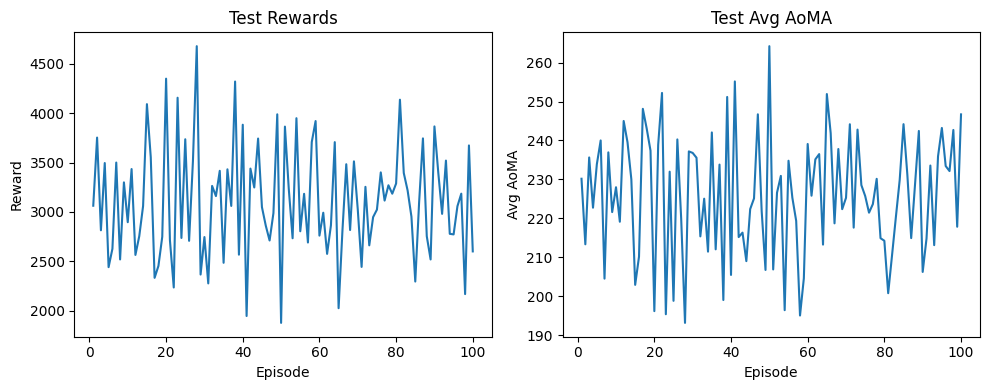

In [4]:
# --- 修改后的测试函数，不使用探索 (epsilon=0)，并打印每集信息 ---
def test(agent, num_episodes=100):
    env = UAVEnv()
    agent.epsilon = 0.0
    rewards, aoas = [], []
    anchored = 0

    for ep in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward


        avg_aoa = env.aoa_total / env.alarm_count if env.alarm_count > 0 else 0
        rewards.append(total_reward)
        aoas.append(avg_aoa)
        if env.anchored:
            anchored += 1

        # 每集打印详细信息
        print(
            f"Test Ep {ep+1:4d} | Reward: {total_reward:10.2f}"
            f" | Avg AoMA: {avg_aoa:8.2f} ({env.aoa_total:8.0f}/{env.alarm_count:2d})"
            f" | Early Stop: {env.stop_reason}"
            f" | Stopped at: {env.t}"
            f" | epsilon: {agent.epsilon:.4f}"
        )

    # 汇总结果
    print(f"\nTest over {num_episodes} episodes")
    print(f"Average Reward : {np.mean(rewards):.2f}")
    print(f"Average AoMA   : {np.mean(aoas):.2f}")
    print(f"Anchored Count : {anchored} ({anchored/num_episodes*100:.1f}%)")

    # 可视化
    episodes = np.arange(1, num_episodes+1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(episodes, rewards)
    plt.title("Test Rewards")
    plt.xlabel("Episode"); plt.ylabel("Reward")
    plt.subplot(1,2,2)
    plt.plot(episodes, aoas)
    plt.title("Test Avg AoMA")
    plt.xlabel("Episode"); plt.ylabel("Avg AoMA")
    plt.tight_layout()
    plt.show()

# 执行测试

test(agent, num_episodes=100)

# …existing code…
#

In [5]:
import torch
model_path = "uav_dqn.pth"
torch.save(agent.policy_net.state_dict(), model_path)
print(f"Saved policy net to {model_path}")

Saved policy net to uav_dqn.pth


In [6]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# ---------------------------
# 独立绘制并保存为PDF的可视化函数
# ---------------------------
def plot_and_save_training_results(rewards, aoa, anchors, aoma_max, success, window_size=100):
    episodes = np.arange(1, len(rewards)+1)
    
    def moving_average(data, window):
        return pd.Series(data).rolling(window=window, min_periods=1).mean().values
    
    rewards_ma = moving_average(rewards, window_size)
    anchors_ma = moving_average(anchors, window_size)
    aoma_max_ma = moving_average(aoma_max, window_size)
    success_ma = moving_average(success, window_size)
    
    # 1. Reward Curve
    fig1 = go.Figure()
    
    # 原始数据作为背景（淡蓝色）
    fig1.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards,
            mode='lines',
            name='Raw Reward',
            line=dict(color='lightblue', width=1, dash='solid'),
            opacity=0.6
        )
    )
    
    # 滑动平均（醒目颜色）
    fig1.add_trace(
        go.Scatter(
            x=episodes, 
            y=rewards_ma,
            mode='lines',
            name=f'Reward MA({window_size})',
            line=dict(color='darkblue', width=3)
        )
    )
    
    fig1.update_layout(
        title="Training Reward Curve",
        xaxis_title="Episode",
        yaxis_title="Reward",
        width=800,
        height=500,
        showlegend=True
    )
    
    # 保存为PDF
    fig1.write_image("reward_curve.pdf", format="pdf")
    fig1.show()
    
    # 2. AoMA Curve (仅成功完成的episodes)
    fig2 = go.Figure()
    
    if aoa:  # 确保有成功完成的episode数据
        # 提取episode索引和对应的AoMA值
        aoa_episodes = [item[1] + 1 for item in aoa]  # episode索引 (从1开始显示)
        aoa_values = [item[0] for item in aoa]        # AoMA值
        
        # 计算AoMA的滑动平均
        aoa_ma = moving_average(aoa_values, min(window_size, len(aoa_values)))
        
        # 原始AoMA数据（淡红色背景）
        fig2.add_trace(
            go.Scatter(
                x=aoa_episodes,
                y=aoa_values,
                mode='lines+markers',
                name='Raw AoMA',
                line=dict(color='lightcoral', width=1),
                marker=dict(size=3, color='lightcoral'),
                opacity=0.6
            )
        )
        
        # AoMA滑动平均（醒目红色）
        fig2.add_trace(
            go.Scatter(
                x=aoa_episodes,
                y=aoa_ma,
                mode='lines',
                name=f'AoMA MA({window_size})',
                line=dict(color='crimson', width=3)
            )
        )
        
        fig2.update_layout(
            title="AoMA Curve (Successful Episodes Only)",
            xaxis_title="Episode",
            yaxis_title="Average AoMA",
            width=800,
            height=500,
            showlegend=True
        )
    else:
        # 添加文本提示
        fig2.add_annotation(
            text="No successful episodes",
            x=0.5, y=0.5,
            xref="paper", yref="paper",
            showarrow=False,
            font=dict(size=14, color="gray")
        )
        
        fig2.update_layout(
            title="AoMA Curve (Successful Episodes Only)",
            xaxis_title="Episode",
            yaxis_title="Average AoMA",
            width=800,
            height=500
        )
    
    # 保存为PDF
    fig2.write_image("aoma_curve.pdf", format="pdf")
    fig2.show()
    
    # 3. Early Stop Types
    fig3 = go.Figure()
    
    # 原始数据点
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors,
            mode='markers',
            name='Raw Anchored',
            marker=dict(color='moccasin', size=3),
            opacity=0.6
        )
    )
    
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max,
            mode='markers',
            name='Raw AoMA Max',
            marker=dict(color='lightcoral', size=3),
            opacity=0.6
        )
    )
    
    # 滑动平均线
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=anchors_ma,
            mode='lines',
            name=f'Anchored MA({window_size})',
            line=dict(color='darkorange', width=2)
        )
    )
    
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=aoma_max_ma,
            mode='lines',
            name=f'AoMA Max MA({window_size})',
            line=dict(color='red', width=2)
        )
    )
    
    # 成功率滑动平均线
    fig3.add_trace(
        go.Scatter(
            x=episodes,
            y=success_ma,
            mode='lines',
            name=f'Success MA({window_size})',
            line=dict(color='green', width=2)
        )
    )
    
    fig3.update_layout(
        title="Early Stop Types Analysis",
        xaxis_title="Episode",
        yaxis_title="Stop Rate (Moving Average)",
        width=800,
        height=500,
        showlegend=True
    )
    
    # 保存为PDF
    fig3.write_image("early_stop_analysis.pdf", format="pdf")
    fig3.show()
    
    print("PDF files saved:")
    print("- reward_curve.pdf")
    print("- aoma_curve.pdf") 
    print("- early_stop_analysis.pdf")

# 调用新的可视化函数
plot_and_save_training_results(rewards, aoa, anchors, aoma_max, success, window_size=100)

PDF files saved:
- reward_curve.pdf
- aoma_curve.pdf
- early_stop_analysis.pdf
